# Model Development

Begin documenting models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import string, re
import pandas_profiling
import itertools 
import local_modules.slack as slack
from progressbar import Bar, BouncingBar, Counter, ETA, \
    AdaptiveETA, FileTransferSpeed, FormatLabel, Percentage, \
    ProgressBar, ReverseBar, RotatingMarker, \
    SimpleProgress, Timer, UnknownLength
pbar = ProgressBar()
%store -r train_features   
%store -r test_features
%store -r train_labels
%store -r test_labels

In [23]:
%reload_ext ipycache

In [2]:
import pickle

In [3]:
loaded_model = pickle.load(open('models/model.pkl', 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

ModuleNotFoundError: No module named 'azureml.automl'

In [8]:
train_features

matrix([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.839 ,  0.3182],
        [ 0.    ,  0.    ,  0.    , ...,  0.109 ,  0.891 , -0.296 ],
        [ 0.    ,  0.    ,  0.    , ...,  0.31  ,  0.69  , -0.5574],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.17  ,  0.83  , -0.5423],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  1.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  1.    ,  0.    ]])

In [9]:
train_labels.describe()

count    11666.000000
mean         0.635093
std          0.671481
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: label, dtype: float64

## Sample model #1: Random Forest

Testing a random forest model on predicting fake news

In [12]:
%%cache models/voting_classifier.pkl eclf1

# Import the model we are using
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
classifier.fit(train_features, train_labels)

clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',
                          random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(train_features, train_labels)
print(eclf1.predict(train_features))
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators = 1000, oob_score = True,
#                            bootstrap = True, random_state = 42) # Instantiate model with 1000 decision trees
# rf.fit(train_features, train_labels) # Train the model on training data
# slack.SlackNotification('BK_slackbot', 'Random forest has finished training.')

/home/bking/virtualenvs/Fake_News_Data_Cup-bh3btNcR/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[0 0 1 ... 1 0 0]


FileNotFoundError: [Errno 2] No such file or directory: '/home/bking/Projects/pipenvs/Fake_News_Data_Cup/models/models/voting_classifier.pkl'

In [ ]:
slack.SlackNotification('BK_slackbot', 'Random forest has finished training.')

In [ ]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])



np.array_equal(eclf1.named_estimators_.lr.predict(X),
               eclf1.named_estimators_['lr'].predict(X))

eclf2 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft')
eclf2 = eclf2.fit(X, y)
print(eclf2.predict(X))

eclf3 = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
       voting='soft', weights=[2,1,1],
       flatten_transform=True)
eclf3 = eclf3.fit(X, y)
print(eclf3.predict(X))

print(eclf3.transform(X).shape)


In [32]:
%%cache voting_classifier.pkl eclf1

eclf1

[Saved variables 'eclf1' to file '/home/bking/Projects/pipenvs/Fake_News_Data_Cup/voting_classifier.pkl'.]


In [13]:
predictions = eclf1.predict(test_features)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)

In [14]:
cm

array([[1392,  451,   30],
       [ 711,  843,   44],
       [ 222,  185,   11]])

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()

Confusion matrix, without normalization
[[1392  451   30]
 [ 711  843   44]
 [ 222  185   11]]


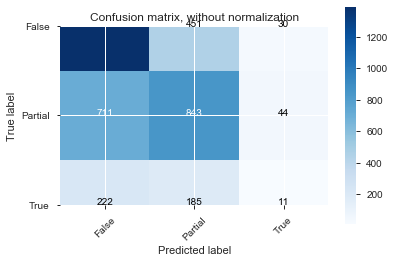

In [16]:
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['False', 'Partial', 'True'],
                      title='Confusion matrix, without normalization')

In [33]:
from sklearn.metrics import accuracy_score
predictions = classifier.predict(test_features)
print("Training accuracy is: ", accuracy_score(train_labels, classifier.predict(train_features)))
print("Test accuracy is: ", accuracy_score(test_labels, predictions))

Training accuracy is:  0.9368249614263672
Test accuracy is:  0.5793263049627153


BAD MODEL

## Brute force models using Hunga Bunga

In [4]:
from local_modules.hunga_bunga import HungaBungaClassifier

In [ ]:
clf = HungaBungaClassifier(brain=True)
clf.fit(train_features, train_labels)

Scoring criteria: accuracy
--------------- model 1/15 ---------------
SGDClassifier
--------------- model 2/15 ---------------
LogisticRegression
--------------- model 3/15 ---------------
Perceptron
--------------- model 4/15 ---------------
PassiveAggressiveClassifier
--------------- model 5/15 ---------------
MLPClassifier
best score: 0.5143958868894601 time/clf: 2.819 seconds
best params:
{'activation': 'tanh',
 'batch_size': 50,
 'early_stopping': True,
 'hidden_layer_sizes': (64,),
 'learning_rate': 'invscaling',
 'max_iter': 500}
--------------- model 6/15 ---------------
KMeans
best score: 0.407369323050557 time/clf: 0.149 seconds
best params:
{'algorithm': 'elkan', 'init': 'random', 'n_clusters': 3}
--------------- model 7/15 ---------------
KNeighborsClassifier
--------------- model 8/15 ---------------
NearestCentroid
best score: 0.4011139674378749 time/clf: 0.004 seconds
best params:
{'metric': 'manhattan', 'shrink_threshold': 2}
--------------- model 9/15 ---------------
R

In [4]:
loaded_model = pickle.load(open("models/model.pkl", 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

ModuleNotFoundError: No module named 'azureml'